In [26]:
import pypsa 
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


INFO:pypsa.network.index:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.network.io:Imported network 'PyPSA-Eur' has buses, carriers, generators, lines, links, loads, storage_units, transformers


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x24b8683a3c0>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x24b85283e90>,
  'Line': <matplotlib.collections.LineCollection at 0x24b84f8be90>,
  'Transformer': <matplotlib.collections.LineCollection at 0x24b84fbde50>},
 'flows': {}}

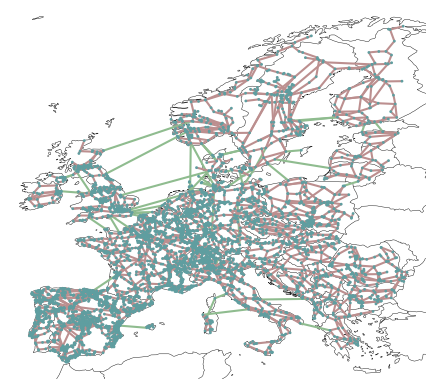

In [27]:
# load network
#n = pypsa.Network("../data/networks/base.nc") # base has only lines, transformers and branches
# n = pypsa.Network("../data/networks/elec_s_256_ec.nc")
n = pypsa.Network("../data/networks/elec.nc")
# n = pypsa.Network("../pypsa-eur/results/test-elec/networks/base_s_6_elec_.nc")
# plot network
n.plot()

In [28]:
# in pypsa-eur hydro reservoirs are not modelled as generators but as storage units
print(n.storage_units[n.storage_units["carrier"] == "hydro"].info())
# HydroStorage_CSV = n.storage_units[n.storage_units["carrier"] == "hydro"].to_csv("../results/sandbox_hydro_storage_units.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 1709 entries, 0 hydro to 4199 hydro
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   bus                                 1709 non-null   object 
 1   control                             1709 non-null   object 
 2   type                                1709 non-null   object 
 3   p_nom                               1709 non-null   float64
 4   p_nom_mod                           1709 non-null   float64
 5   p_nom_extendable                    1709 non-null   bool   
 6   p_nom_min                           1709 non-null   float64
 7   p_nom_max                           1709 non-null   float64
 8   p_nom_set                           0 non-null      float64
 9   p_min_pu                            1709 non-null   float64
 10  p_max_pu                            1709 non-null   float64
 11  p_set                               

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x24b81a80d70>},
 'branches': {},
 'flows': {}}

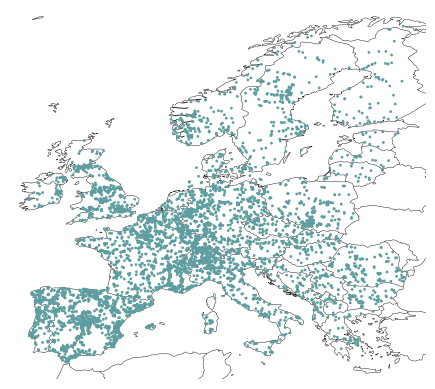

In [ ]:
# plotting of buses with hydro storage units
TARGET_COUNTRIES = ["DE", "BE", "LU"]
min_pnom = 100e6                              # more than 1 MW nominal power

filtered_storage_units = n.storage_units[
    (n.storage_units["carrier"] == "hydro") &
    (n.storage_units["p_nom"] > min_pnom)
]

buses_with_hydro = filtered_storage_units.bus.unique()

filtered_buses = n.buses[
    (n.buses.index.isin(buses_with_hydro)) &
    (n.buses.country.isin(TARGET_COUNTRIES))
]

n.plot(branch_components=n.buses[filtered_buses.index])

In [ ]:
print(n.generators[n.generators["carrier"] == "ror"])

             bus control type    p_nom  p_nom_mod  p_nom_extendable  \
name                                                                  
10 hydro    3358      PQ       172.000        0.0             False   
13 hydro    2466      PQ       345.000        0.0             False   
18 hydro    3582      PQ       156.000        0.0             False   
19 hydro    3370      PQ       179.000        0.0             False   
21 hydro    3586      PQ       156.200        0.0             False   
...          ...     ...  ...      ...        ...               ...   
4164 hydro  3321      PQ         0.090        0.0             False   
4165 hydro  3318      PQ         0.160        0.0             False   
4166 hydro  3485      PQ         0.095        0.0             False   
4184 hydro  4561      PQ         1.893        0.0             False   
4185 hydro  3476      PQ         1.000        0.0             False   

            p_nom_min  p_nom_max  p_nom_set  p_min_pu  ...  min_up_time  \
n

In [ ]:
print(n.lines.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 10236 to 7308
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bus0                6000 non-null   object 
 1   bus1                6000 non-null   object 
 2   type                6000 non-null   object 
 3   x                   6000 non-null   float64
 4   r                   6000 non-null   float64
 5   g                   6000 non-null   float64
 6   b                   6000 non-null   float64
 7   s_nom               6000 non-null   float64
 8   s_nom_mod           6000 non-null   float64
 9   s_nom_extendable    6000 non-null   bool   
 10  s_nom_min           6000 non-null   float64
 11  s_nom_max           6000 non-null   float64
 12  s_nom_set           0 non-null      float64
 13  s_max_pu            6000 non-null   float64
 14  capital_cost        6000 non-null   float64
 15  active              6000 non-null   bool   
 16  build_y